<a href="https://colab.research.google.com/github/ocoropuj/quantum-system/blob/main/Quantum_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [6]:
# @title Libraries
import cupy as cp


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

from matplotlib.animation import FFMpegWriter

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

from scipy.fftpack import fft2, ifft2
from scipy.optimize import curve_fit
from scipy.integrate import simps, trapz
from numpy.fft import fft2, ifft2

from matplotlib import animation
from matplotlib.animation import FuncAnimation


import time

import random

In [7]:
# @title Particle Class
class Particle2D:
    def __init__(self, x_position=0, y_position=0, x_momentum=0, y_momentum=0, charge=0, mass=0, scale=1e-3, potential=None, hbar=1, space_size=1000):

        self.scale = scale
        self.hbar = hbar#1.05457182e-34
        self.c = 3
        self.E = 0
        self.space_size = space_size
        self.Range = 50
        self.position = [x_position, y_position]
        self.momentum = [x_momentum, y_momentum]
        self.charge = charge
        self.mass = mass
        self.momentum_wavefunction = None
        self.potential = potential
        self.x = np.linspace(0, self.space_size - 1, self.space_size)
        self.y = np.linspace(0, self.space_size - 1, self.space_size)

        momentum_magnitude = np.sqrt(self.momentum[0]**2 + self.momentum[1]**2)
        omega = (2 * np.pi * self.hbar) / momentum_magnitude
        E = self.hbar * omega
        self.E = max(E, self.hbar/2)

        # Initialize the wave function as a Gaussian
        #sigma = self.hbar / (2 * np.sqrt(2 * np.log(2) * 2 * self.mass * self.E))
        sigma = self.scale/self.space_size

        x, y = np.meshgrid(self.x - self.position[0], self.y - self.position[1])
        self.wavefunction = np.nan_to_num(np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (np.pi * sigma**2) , nan=0)
        self.wavefunction /= np.sqrt(np.sum(np.abs(self.wavefunction)**2))

        self.momentum_wavefunction = None
        self.potential = potential


    def plot_wavefunction(self, Range_, pdf=False, Complex=False, momentum=False):
        # Extract the submatrix based on the specified limits
        x_min, x_max = int(self.space_size / 2 - Range_), int(self.space_size / 2 + Range_)
        y_min, y_max = int(self.space_size / 2 - Range_), int(self.space_size / 2 + Range_)

        if momentum == False:
            wf = self.wavefunction
        elif momentum == True:
            wf = self.momentum_wavefunction

        if pdf == False:
            if Complex == False:
                submatrix = wf[x_min:x_max, y_min:y_max]
            elif Complex == True:
                submatrix = -1j*wf[x_min:x_max, y_min:y_max]
        elif pdf == True:
            submatrix = np.abs(wf[x_min:x_max, y_min:y_max])**2

        # Create meshgrid for x and y values
        x_values = np.arange(submatrix.shape[0]) + x_min
        y_values = np.arange(submatrix.shape[1]) + y_min
        X, Y = np.meshgrid(x_values, y_values)

        # Create a 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot the surface
        ax.plot_surface(X, Y, submatrix, cmap='viridis')  # You can change the colormap to your preference

        # Set labels for the axes
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        if pdf == False:
            ax.set_zlabel('Ψ(x)')
            plt.title('Wavefunction')
        elif pdf == True:
            ax.set_zlabel('||Ψ(x)||^2')
            plt.title('Density')
        # Show the plot
        plt.show()

    def create_gaussian_wavefunction(self, mean, sigma):
            x, y = np.meshgrid(self.x - mean[0], self.y - mean[1])
            self.wavefunction = np.nan_to_num(np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (np.pi * sigma**2), nan=0)
            self.wavefunction /= np.sqrt(np.sum(np.abs(self.wavefunction)**2))

    def calculate_T(self):
        # Calculate the kinetic energy using the Laplacian operator
        laplacian = np.gradient(np.gradient(self.wavefunction, self.x, axis=0), self.x, axis=0) + \
                    np.gradient(np.gradient(self.wavefunction, self.y, axis=1), self.y, axis=1)
        kinetic_energy = np.sum(-self.hbar**2 * laplacian / (2 * self.mass))
        return kinetic_energy

    def calculate_V(self):
        # Compute the potential energy
        if self.potential == None:
            return 0
        potential_energy = np.sum(self.potential * self.wavefunction)
        return potential_energy

    def calculate_total_energy(self):
        if self.wavefunction is None:
            # Calculate the total energy based on the given formula
            momentum_magnitude = np.sqrt(self.momentum[0]**2 + self.momentum[1]**2)
            omega = (2 * np.pi * self.hbar) / momentum_magnitude
            E = self.hbar * omega
            self.E = E

        else:
            # Calculate the kinetic and potential energy
            kinetic_energy = self.calculate_T()
            potential_energy = self.calculate_V()
            total_energy = kinetic_energy + potential_energy
            self.E = total_energy

        return self.E

    def calculate_Expected_X(self):
        # Compute the expected value of position
        expected_x = np.sum(self.x * np.abs(self.wavefunction)**2) / np.sum(np.abs(self.wavefunction)**2)
        return expected_x

    def calculate_Expected_P(self):
        # Compute the expected value of momentum
        expected_p = np.sum(self.hbar * self.momentum_wavefunction * np.conj(self.wavefunction))
        return expected_p

    def calculate_Expected_E(self):
        # Compute the expected value of total energy
        expected_energy = np.sum(self.E * np.abs(self.wavefunction)**2)
        return expected_energy

    def collapse_wavefunction(self):
        # Calculate the probability distribution functions (PDFs) for position and momentum
        pdf_x = np.abs(self.wavefunction)**2 / np.sum(np.abs(self.wavefunction)**2)
        pdf_p = np.abs(self.momentum_wavefunction)**2 / np.sum(np.abs(self.momentum_wavefunction)**2)

        # Generate random variables for position using random_variable_2D
        random_x, random_y = self.random_variable_2D(pdf_x)

        # Update self.position and self.momentum (as integers)
        self.position = [random_x, random_y]

        # Reset the wavefunction
        #self.wavefunction = np.zeros((self.space_size, self.space_size))
        #self.wavefunction[self.space_size // 2, self.space_size // 2] = 1.0 / self.space_size

        # Initialize the wave function as a Gaussian
        sigma = self.scale/self.space_size#self.hbar / 2

        x, y = np.meshgrid(self.x - self.position[0], self.y - self.position[1])
        self.wavefunction = np.nan_to_num(np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (np.pi * sigma**2) , nan=0)
        self.wavefunction /= np.sqrt(np.sum(np.abs(self.wavefunction)**2))



    def random_variable_2D(self, pdf):
        n = len(pdf)
        pdf_1d = pdf.flatten()
        weights = pdf_1d / (sum(pdf_1d))
        random_index = np.random.choice(a=np.arange(0, len(weights)), p=weights)
        # Find the row and column indices in the original 2D mesh grid
        x = random_index // n
        y = random_index % n

        return x, y


    def update_wavefunction(self, delta_t = 0.01):
        if (
            self.wavefunction is None
            or self.wavefunction.shape != (self.space_size, self.space_size)
            or np.count_nonzero(self.wavefunction) < 1
        ):
            # Initialize the wave function as a Gaussian
            sigma = self.scale / self.space_size#self.hbar / (2 * np.sqrt(2 * np.log(2) * 2 * self.mass * self.E))

            x, y = np.meshgrid(self.x - self.position[0], self.y - self.position[1])
            self.wavefunction = np.nan_to_num(np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (np.pi * sigma**2) , nan=0)
            self.wavefunction /= np.sqrt(np.sum(np.abs(self.wavefunction)**2))

            #self.wavefunction = np.zeros((self.space_size, self.space_size))
            #self.wavefunction[self.space_size // 2, self.space_size // 2] = 1.0 / self.space_size



        else:
            # Update the wave function using the time-dependent Schrödinger equation
            laplacian = np.nan_to_num(np.array((np.gradient(np.gradient(self.wavefunction, self.x, axis=0), self.x, axis=0)
                        + np.gradient(np.gradient(self.wavefunction, self.y, axis=1), self.y, axis=1)), dtype=complex), nan=0)

            if self.potential is not None:
                potential_term = np.nan_to_num(self.potential * self.wavefunction, nan=0)
                wf = (-1j / self.hbar) * delta_t * (-(self.hbar**2 / (2 * self.mass)) * laplacian + potential_term)

            else:
                wf = np.nan_to_num(np.asarray(self.wavefunction, dtype=complex), nan=0)
                wf -= (-1j / self.hbar) * delta_t * (-(self.hbar**2 / (2 * self.mass)) * laplacian)


            self.wavefunction = wf/(np.sqrt(np.sum(np.abs(wf)**2)))

        self.momentum_wavefunction = np.fft.fft2(self.wavefunction)

    def calculate_mean_and_stddev(self, Print=False):
        # Calculate the mean position using the wave function and position coordinates
        mean_x = np.sum(self.x * np.abs(self.wavefunction)**2)
        mean_y = np.sum(self.y * np.abs(np.transpose(self.wavefunction))**2)

        # Calculate the standard deviation in both x and y directions
        stddev_x = np.sqrt(np.sum((self.x - mean_x)**2 * np.abs(self.wavefunction)**2))
        stddev_y = np.sqrt(np.sum((self.y - mean_y)**2 * np.abs(np.transpose(self.wavefunction))**2))

        if Print == True:
            print(f'µ_x={mean_x}, µ_y={mean_y}, σ={np.sqrt(stddev_x**2 + stddev_y**2)}')

        return mean_x, mean_y, stddev_x, stddev_y


In [8]:
# @title Particle GPU Class

def process_potential(potential):
    """Process potential array to handle NaN and infinity values.

    Args:
        potential: The potential array to be processed.

    Returns:
        The processed potential array.
    """
    # Replace NaN values with 0
    potential[cp.isnan(potential)] = 0

    # Replace infinity values with the maximum non-infinity value
    non_inf_max = 1e10 * cp.max(potential[cp.isfinite(potential)])
    potential[cp.isinf(potential)] = non_inf_max

    return potential

class Particle2D_GPU:
    def __init__(self, x_position=0, y_position=0, x_momentum=0, y_momentum=0, charge=0, mass=0, scale=1e-3, potential=None, hbar=1, space_size=1000):

        self.scale = scale
        self.hbar = hbar
        self.c = 3
        self.E = 0
        self.space_size = space_size
        self.Range = 50
        self.position = cp.array([x_position, y_position])
        self.momentum = cp.array([x_momentum, y_momentum])
        self.charge = charge
        self.mass = mass
        self.momentum_wavefunction = None
        if potential is None:
            self.potential = None
        else:
            self.potential = process_potential(potential)
        self.x = cp.linspace(0, self.space_size - 1, self.space_size)
        self.y = cp.linspace(0, self.space_size - 1, self.space_size)

        momentum_magnitude = cp.sqrt(self.momentum[0]**2 + self.momentum[1]**2)
        omega = (2 * cp.pi * self.hbar) / momentum_magnitude
        E = self.hbar * omega
        self.E = max(E, self.hbar/2)

        # Initialize the wave function as a Gaussian
        sigma = self.scale/self.space_size

        x, y = cp.meshgrid(self.x - self.position[0], self.y - self.position[1])
        self.wavefunction = cp.nan_to_num(cp.exp(-(x**2 + y**2) / (2 * sigma**2)) / (cp.pi * sigma**2) , nan=0)
        self.wavefunction /= cp.sqrt(cp.sum(cp.abs(self.wavefunction)**2))

        self.momentum_wavefunction = None
        self.potential = potential

    def plot_wavefunction(self, Range_, pdf=False, Complex=False, momentum=False):
        # Extract the submatrix based on the specified limits
        x_min, x_max = int(self.space_size / 2 - Range_), int(self.space_size / 2 + Range_)
        y_min, y_max = int(self.space_size / 2 - Range_), int(self.space_size / 2 + Range_)

        if momentum == False:
            wf = self.wavefunction
        elif momentum == True:
            wf = self.momentum_wavefunction

        if pdf == False:
            if Complex == False:
                submatrix = wf[x_min:x_max, y_min:y_max]
            elif Complex == True:
                submatrix = -1j * wf[x_min:x_max, y_min:y_max]
        elif pdf == True:
            submatrix = cp.abs(wf[x_min:x_max, y_min:y_max])**2

        # Create meshgrid for x and y values
        x_values = cp.arange(submatrix.shape[0]) + x_min
        y_values = cp.arange(submatrix.shape[1]) + y_min
        X, Y = cp.meshgrid(x_values, y_values)

        # Create a 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot the surface
        ax.plot_surface(cp.asnumpy(X), cp.asnumpy(Y), cp.asnumpy(submatrix), cmap='viridis')  # Convert CuPy arrays to NumPy arrays for plotting

        # Set labels for the axes
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        if pdf == False:
            ax.set_zlabel('Ψ(x)')
            plt.title('Wavefunction')
        elif pdf == True:
            ax.set_zlabel('||Ψ(x)||^2')
            plt.title('Density')

        # Show the plot
        plt.show()

    def create_gaussian_wavefunction(self, mean=None, sigma=1):
        if mean is None:
            mean = self.position

        # Create a Gaussian wave
        x, y = cp.meshgrid(self.x - mean[0], self.y - mean[1])
        self.wavefunction = cp.nan_to_num(cp.exp(-(x**2 + y**2) / (2 * sigma**2)) / (cp.pi * sigma**2), nan=0)
        self.wavefunction /= cp.sqrt(cp.sum(cp.abs(self.wavefunction)**2))

    def calculate_T(self):
        # Calculate the kinetic energy using the Laplacian operator
        laplacian = cp.gradient(cp.gradient(self.wavefunction, self.x, axis=0), self.x, axis=0) + \
                     cp.gradient(cp.gradient(self.wavefunction, self.y, axis=1), self.y, axis=1)
        kinetic_energy = cp.sum(-self.hbar**2 * laplacian / (2 * self.mass))
        return kinetic_energy.get()  # Convert CuPy array to NumPy array

    def calculate_V(self):
        # Compute the potential energy
        if self.potential is None:
            return 0
        potential_energy = cp.sum(self.potential * self.wavefunction)
        return potential_energy.get()  # Convert CuPy array to NumPy array

    def calculate_total_energy(self):
        if self.wavefunction is None:
            # Calculate the total energy based on the given formula
            momentum_magnitude = cp.sqrt(self.momentum[0]**2 + self.momentum[1]**2)
            omega = (2 * cp.pi * self.hbar) / momentum_magnitude
            E = self.hbar * omega
            self.E = E.get()  # Convert CuPy array to NumPy array

        else:
            # Calculate the kinetic and potential energy
            kinetic_energy = self.calculate_T()
            potential_energy = self.calculate_V()
            total_energy = kinetic_energy + potential_energy
            self.E = total_energy.get()  # Convert CuPy array to NumPy array

        return self.E

    def calculate_mean_and_stddev(self, Print=False):
        # Calculate the mean position using the wave function and position coordinates
        mean_x = cp.sum(self.x * cp.abs(self.wavefunction)**2)
        mean_y = cp.sum(self.y * cp.abs(cp.transpose(self.wavefunction))**2)

        # Calculate the standard deviation in both x and y directions
        stddev_x = cp.sqrt(cp.sum((self.x - mean_x)**2 * cp.abs(self.wavefunction)**2))
        stddev_y = cp.sqrt(cp.sum((self.y - mean_y)**2 * cp.abs(cp.transpose(self.wavefunction))**2))

        if Print:
            print(f'µ_x={mean_x.get()}, µ_y={mean_y.get()}, σ={cp.sqrt(stddev_x.get()**2 + stddev_y.get()**2)}')

        return mean_x, mean_y, stddev_x, stddev_y

    def calculate_Expected_X(self):
        # Compute the expected value of position
        mean_x, mean_y, _, _ = self.calculate_mean_and_stddev()
        return mean_x.get(), mean_y.get()  # Convert CuPy array to NumPy array

    def calculate_Expected_P(self):
        # Compute the expected value of momentum
        expected_p = cp.sum(self.hbar * self.momentum_wavefunction * cp.conj(self.wavefunction))
        return expected_p.get()  # Convert CuPy array to NumPy array

    def calculate_Expected_E(self):
        # Compute the expected value of total energy
        expected_energy = cp.sum(self.E * cp.abs(self.wavefunction)**2)
        return expected_energy.get()  # Convert CuPy array to NumPy array


    def random_variable_2D(self, pdf):
        n = len(pdf)
        pdf_1d = cp.asarray(pdf.flatten())
        weights = pdf_1d / cp.sum(pdf_1d)
        random_index = cp.random.choice(a=cp.arange(0, len(weights)), p=weights)
        # Find the row and column indices in the original 2D mesh grid
        x = random_index // n
        y = random_index % n

        return int(x.get()), int(y.get())  # Convert CuPy array to Python integer

    def collapse_wavefunction(self):
        # Calculate the probability distribution functions (PDFs) for position and momentum
        pdf_x = cp.abs(self.wavefunction)**2 / cp.sum(cp.abs(self.wavefunction)**2)
        pdf_p = cp.abs(self.momentum_wavefunction)**2 / cp.sum(cp.abs(self.momentum_wavefunction)**2)

        # Generate random variables for position using random_variable_2D
        random_x, random_y = self.random_variable_2D(pdf_x)

        # Update self.position and self.momentum (as integers)
        self.position = [random_x, random_y]

        # Initialize the wave function as a Gaussian
        sigma = self.scale / self.space_size  # self.hbar / 2

        x, y = cp.meshgrid(self.x - self.position[0], self.y - self.position[1])
        self.wavefunction = cp.nan_to_num(cp.exp(-(x**2 + y**2) / (2 * sigma**2)) / (cp.pi * sigma**2), nan=0)
        self.wavefunction /= cp.sqrt(cp.sum(cp.abs(self.wavefunction)**2))


    def update_wavefunction(self, delta_t=1):
        if (
            self.wavefunction is None
            or self.wavefunction.shape != (self.space_size, self.space_size)
            or cp.count_nonzero(self.wavefunction) < 1
        ):
            # Initialize the wave function using create_gaussian_wavefunction
            self.create_gaussian_wavefunction(self.position, self.scale / self.space_size)
        else:
            # Update the wave function using the time-dependent Schrödinger equation
            laplacian = cp.nan_to_num(cp.array(
                (cp.gradient(cp.gradient(self.wavefunction, self.x, axis=0), self.x, axis=0)
                + cp.gradient(cp.gradient(self.wavefunction, self.y, axis=1), self.y, axis=1)), dtype=complex), nan=0)

            if self.potential is not None:
                potential_term = cp.nan_to_num(self.potential * self.wavefunction, nan=0)
                wf = cp.nan_to_num(cp.asarray(self.wavefunction, dtype=complex), nan=0)
                wf += (1j / self.hbar) * delta_t * ((self.hbar**2 / (2 * self.mass)) * laplacian - potential_term)
            else:
                wf = cp.nan_to_num(cp.asarray(self.wavefunction, dtype=complex), nan=0)
                wf += (1j / self.hbar) * delta_t * ((self.hbar**2 / (2 * self.mass)) * laplacian)

            self.wavefunction = wf / (cp.sqrt(cp.sum(cp.abs(wf)**2)))

        self.momentum_wavefunction = cp.fft.fft2(self.wavefunction)


In [9]:
# @title Estimate Gaussian
def estimate_gaussian(particle, mean_guess=500, every_two=True, estimate_mean=True, Range=50):
    wf = ((np.abs(particle.wavefunction.get()))**2)[500]
    WF = (np.abs(particle.wavefunction.get()))**2

    if every_two == True:
        data = wf[::2]/sum(wf[::2])
        mean_guess = mean_guess/2
    else:
        data = wf/sum(wf)
        mean_guess = mean_guess

    # Define the function for a Gaussian distribution
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

    # Estimate the initial parameters for the fit
    amplitude_guess = np.max(data)
    stddev_guess = 5  # An initial guess for the standard deviation

    # Fit the Gaussian to your data
    params, covariance = curve_fit(gaussian, np.arange(len(data)), data, p0=[amplitude_guess, mean_guess, stddev_guess])

    # Extract the estimated standard deviation
    estimated_stddev = params[2]
    estimated_mean = params[1]

    # Plot the original data and the fitted Gaussian curve
    x = np.arange(len(wf))

    if estimate_mean == True:
        mean = estimated_mean
    else:
        mean = mean_guess

    if every_two == True:
        mean *= 2

    print("Estimated Standard Deviation:", estimated_stddev, "Mean:", mean)

    fit_curve = gaussian(x, 1, mean, 2 * estimated_stddev)

    plt.figure(figsize=(8, 4))

    plt.plot(x, wf/(sum(2*wf[::2])), 'b-', label='Wave Function')
    plt.plot(x, fit_curve/sum(fit_curve), 'r-', label='Fitted Gaussian')

    plt.xlim(mean-Range,mean+Range)

    plt.legend()
    plt.show()

### Orders

# Code 1 Particle

In [40]:
# @title Variables
charge = 10
mass = 1

space_size = 1000
pos = space_size * np.array([0.5,0.5])
mom = np.array([0,0])
hbar = 1

In [41]:
# @title Electric Potential
def electric_potential(charge, x0, y0, space_size, k=10):
  """Calculates the electric potential at a given point.

  Args:
    charge: The charge of the object.
    x0: The x-coordinate of the point.
    y0: The y-coordinate of the point.
    space_size: The size of the space in which the potential is calculated.
    k: The Coulomb constant.
    Actual k = 8.99e9 #Coulomb's constant (in Nm^2/C^2)

  Returns:
    The electric potential at the given point.
  """
  def define_potential(charge=charge, x0=x0, y0=y0, space_size=space_size, k=k):
      x = np.linspace(0, space_size -1, space_size)
      y = np.linspace(0, space_size -1, space_size)
      xx, yy = np.meshgrid(x, y)

      r = np.sqrt((xx - x0) ** 2 + (yy - y0) ** 2)

      return k * charge / r

  return define_potential()

x0 = pos[0]
y0 = pos[0]

k = 1
electric_potential1 = electric_potential(charge, x0, y0, space_size, k=3*k)
electric_potential2 = electric_potential(charge, x0, -(y0-500)+500, space_size, k=2*k)
electric_potential3 = electric_potential(charge, x0-np.sqrt(10), y0, space_size, k=k)

electric_potential = electric_potential3 #+ electric_potential2 + electric_potential1

<ipython-input-41-1689cda4540a>:23: RuntimeWarning: divide by zero encountered in divide
  return k * charge / r


In [ ]:
# @title plot V
num_levels = 100


# Define your contour plot
contour = plt.contourf(-electric_potential, cmap='viridis', levels=num_levels, extend='both')

# Set the plot limits
plt.xlim(450, 550)
plt.ylim(450, 550)

# Add a colorbar
colorbar = plt.colorbar(contour)

# Set a label for the colorbar (if needed)
colorbar.set_label('Potential (V)')

plt.show()

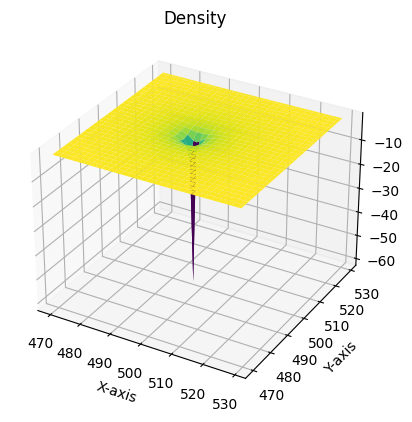

In [43]:
Range = 30
submatrix = -electric_potential[500-Range:500+Range, 500-Range:500+Range]


# Create meshgrid for x and y values
x_values = cp.arange(submatrix.shape[0]) + 500-Range
y_values = cp.arange(submatrix.shape[1]) + 500-Range
X, Y = cp.meshgrid(x_values, y_values)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

        # Plot the surface
ax.plot_surface(cp.asnumpy(X), cp.asnumpy(Y), cp.asnumpy(submatrix), cmap='viridis')  # Convert CuPy arrays to NumPy arrays for plotting

        # Set labels for the axes
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
plt.title('Density')

        # Show the plot
plt.show()

In [28]:
# @title Definitions
space_size = 1000
pos = space_size * np.array([0.5,0.5])
hbar = 1
charge = 1

def electric_potential_GPU(charge, x0, y0, space_size, k=10):
    """Calculates the electric potential at a given point.

    Args:
        charge: The charge of the object.
        x0: The x-coordinate of the point.
        y0: The y-coordinate of the point.
        space_size: The size of the space in which the potential is calculated.
        k: The Coulomb constant.
        Actual k = 8.99e9 #Coulomb's constant (in Nm^2/C^2)

    Returns:
        The electric potential at the given point.
    """
    def define_potential(charge=charge, x0=x0, y0=y0, space_size=space_size, k=k):
        x = cp.linspace(0, space_size - 1, space_size)
        y = cp.linspace(0, space_size - 1, space_size)
        xx, yy = cp.meshgrid(x, y)

        r = cp.sqrt((xx - x0) ** 2 + (yy - y0) ** 2)

        # Calculate potential
        potential = k * charge / r

        # Replace NaN values with 0
        potential[cp.isnan(potential)] = 0

        # Replace infinity values with the maximum non-infinity value
        non_inf_max = cp.max(potential[cp.isfinite(potential)])
        potential[cp.isinf(potential)] = non_inf_max

        return potential

    return define_potential()

k = 1e-1
pos = space_size * cp.array([0.5, 0.5])
hbar = 1

electric_potential3 = electric_potential_GPU(charge, 510, 500, space_size, k=k)
electric_potential = electric_potential3

In [ ]:
# @title Compute
particle = Particle2D_GPU(x_position=pos[0], y_position=pos[1], x_momentum=mom[0], y_momentum=mom[1],
                          charge=charge, mass=mass, hbar=hbar, space_size=space_size, potential=electric_potential)
particle.create_gaussian_wavefunction(mean=pos, sigma=1)

particle.plot_wavefunction(Range_=30, pdf=True)
particle.calculate_mean_and_stddev(Print = True)

positions = []
arrayWF = []

for i in range(900+1):
    if i%25 == 0 and i<500 or i%150 == 0:
        # @title plot V
        #num_levels = 100

        # Define your contour plot
        #contour = plt.contourf(np.abs(particle.wavefunction.get())**2, cmap='viridis', levels=num_levels, extend='both')

        # Set the plot limits
        #plt.xlim(425, 575)
        #plt.ylim(425, 575)

        # Add a colorbar
        #colorbar = plt.colorbar(contour)

        # Set a label for the colorbar (if needed)
        #colorbar.set_label('pdf')

        #plt.show()


        particle.plot_wavefunction(pdf=True, Range_=75)
        print(i)
    particle.update_wavefunction(1)
    arrayWF.append(particle.wavefunction)
    positions.append(particle.calculate_mean_and_stddev())

particle.plot_wavefunction(Range_=75, pdf=True)
particle.calculate_mean_and_stddev(Print = True)


In [ ]:
particle.plot_wavefunction(Range_=75, pdf=True)
num_levels = 100

        # Define your contour plot
contour = plt.contourf(np.abs(particle.wavefunction.get())**2, cmap='viridis', levels=num_levels, extend='both')

        # Set the plot limits
plt.xlim(425, 575)
plt.ylim(425, 575)

        # Add a colorbar
colorbar = plt.colorbar(contour)

colorbar.set_label('pdf')

plt.show()


In [ ]:
estimate_gaussian(particle, Range=50)

In [ ]:
x_and_y = cp.array(positions)[:,0:2].get()#[:50]
stds = cp.linalg.norm(cp.array(positions)[:,2:], axis=1).get()

x, y = np.transpose(x_and_y)
r = np.sqrt((x-500)**2 + (y-500)**2)
plt.title('Position')
plt.scatter(x,y)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()
plt.show()

In [ ]:
#sns.histplot(r.get(), kde=True, stat='density')
#plt.show()

plt.plot(r)

plt.ylabel('Displacement: (||r||)')
plt.xlabel('Time (dt)')
plt.grid()
plt.show()

plt.plot(stds[-500:])
plt.grid()
plt.ylabel('Standard Deviation (σ)')
plt.xlabel('Time (dt)')

plt.show()

In [ ]:
vel = np.diff(r)
acc = np.diff(vel)

# Plot the change returns
plt.plot(vel[-200:])
plt.xlabel('Time (dt)')
plt.ylabel('Velocity (d||r||/dt)')
plt.grid()
plt.show()

#plt.plot(acc)
#plt.xlabel('Time')
#plt.ylabel('Acceleration')
#plt.grid()
#plt.show()

In [ ]:
time = np.arange(len(x_and_y))

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot
ax.scatter(time, x, y)

# Set labels for the axes
ax.set_xlabel('Time (Index)')
ax.set_ylabel('X-axis')
ax.set_zlabel('Y-axis')

plt.show()

In [17]:
if False:
    for i, wf in enumerate(arrayWF):
      if i%5 == 0:
        print(i)
        # Define your contour plot
        contour = plt.contourf(wf, cmap='viridis', label='Real', alpha=0.5, levels=num_levels, extend='both', interpolation='bicubic')
        contourI = plt.contourf(-1j*wf, cmap='plasma', label='Imaginary', alpha=0.5, levels=num_levels, extend='both', interpolation='bicubic')

        # Set the plot limits
        plt.xlim(475, 525)
        plt.ylim(475, 525)
        # Add a colorbar
        colorbar = plt.colorbar(contour)
        colorbarI = plt.colorbar(contourI)

        # Set a label for the colorbar (if needed)
        colorbar.set_label(f'Wave function Re(Ψ(x,t={i}))')
        colorbarI.set_label(f'Wave function Im(Ψ(x,t={i}))')

        plt.legend()


        plt.show()

        # Define your contour plot
        contour = plt.contourf(((np.abs(wf))**2), cmap='viridis', levels=num_levels, extend='both', interpolation='bicubic')
        # Set the plot limits
        plt.xlim(475, 525)
        plt.ylim(475, 525)
        # Add a colorbar
        colorbar = plt.colorbar(contour)
        # Set a label for the colorbar (if needed)
        colorbar.set_label(f'PDF ||Ψ(x,t={i})||^2')
        plt.show()


In [19]:
# @title Animate
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

def animate(arrayWF, pdf=False, Range_=35, fps=30, Complex=False, TwoD=False):
    x_min, x_max = 500 - Range_, 500 + Range_
    y_min, y_max = 500 - Range_, 500 + Range_

    if pdf:
        Str = 'pdf'
    else:
        Str = 'wf' if not Complex else 'complex_wf'

    # Convert CuPy array to NumPy if needed
    if isinstance(arrayWF[0], cp.ndarray):
        arrayWF = [cp.asnumpy(frame) for frame in arrayWF]

    fig = plt.figure()

    if pdf:
        arrayWF = np.abs(arrayWF)**2
    else:
        arrayWF = arrayWF

    if TwoD:
        ax = plt.subplot(111)
        num_levels = 100
        contour = plt.contourf(arrayWF[0], cmap='viridis', levels=num_levels, extend='both')
        colorbar = plt.colorbar(contour)
    else:
        ax = fig.add_subplot(111, projection='3d')

    def update(frame):
        if TwoD:
            ax.clear()
            if Complex:
                contour = plt.contourf((-1j*arrayWF[frame][x_min:x_max, y_min:y_max]).real, cmap='viridis', levels=num_levels, extend='both')
            else:
                contour = plt.contourf((arrayWF[frame][x_min:x_max, y_min:y_max]).real, cmap='viridis', levels=num_levels, extend='both')

        else:
            ax.clear()
            if Complex:
                submatrix_t = ((-1j*arrayWF[frame][x_min:x_max, y_min:y_max]).real)
            else:
                submatrix_t = ((arrayWF[frame][x_min:x_max, y_min:y_max]).real)
            x_values = np.arange(submatrix_t.shape[0]) + x_min
            y_values = np.arange(submatrix_t.shape[1]) + y_min
            X, Y = np.meshgrid(x_values, y_values)
            surface = ax.plot_surface(X, Y, submatrix_t, cmap='viridis')
            ax.set_xlabel('X-axis')
            ax.set_ylabel('Y-axis')
            ax.set_zlabel('Density')
            ax.set_title(f'Time Step: {frame}')

    ani = FuncAnimation(fig, update, frames=len(arrayWF), repeat=False, interval=10)
    writer = FFMpegWriter(fps=fps)
    ani.save(f'animation_{Str}_{len(arrayWF)}{"_2D" if TwoD else ""}.mp4', writer=writer)


In [ ]:
animate(arrayWF, pdf=True, Range_=100, fps=15, Complex=False, TwoD=False)

# Code multiple particles

In [5]:
# @title Multi Particle State
class MultiParticleState_GPU:
    def combine_wavefunctions(self):
        psi_list = [particle.wavefunction for particle in self.particles]
        shape = psi_list[0].shape
        combined_wavefunction = cp.ones(shape + (len(psi_list),), dtype=cp.complex128)

        for psi in psi_list:
            combined_wavefunction *= cp.expand_dims(psi, axis=-1)

        return cp.squeeze(combined_wavefunction)

    def __init__(self, particles, hbar=1):
        self.particles = particles

        # Check if the number of particles is consistent
        if not all(isinstance(p, Particle2D_GPU) for p in particles):
            raise ValueError("All elements in the 'particles' list must be instances of Particle2D_GPU.")

        if len(set(p.space_size for p in particles)) != 1:
            raise ValueError("All particles must have the same 'space_size'.")
        self.hbar = hbar
        self.n = len(particles)
        self.space_size = particles[0].space_size
        self.Psi = self.combine_wavefunctions()
        self.x_values = cp.linspace(0, self.space_size-1, self.space_size)
        self.y_values = cp.linspace(0, self.space_size-1, self.space_size)
        X, Y = cp.meshgrid(self.x_values, self.y_values, indexing='ij')
        self.X = X
        self.Y = Y
        self.masses = []
        for particle in particles:
            self.masses.append(particle.mass)
        self.charges = []
        for particle in particles:
            self.charges.append(particle.charge)


    def compute_V_k(self, Psi, k, X, Y, c=None):
        if c is None:
            c = cp.ones(Psi.shape[2])

        N = X.shape[0]
        result_matrix = cp.zeros_like(X, dtype=cp.float64)
        denominator = (X - cp.arange(N)[:, None])**2 + (Y - cp.arange(N)[None, :])**2

        for i in range(0, Psi.shape[2]):
            if i != k:
                Psi_magnitude_squared = cp.abs(Psi[:, :, i])**2
                result_matrix += c[i] * Psi_magnitude_squared / cp.maximum(denominator, 1e-5)

        return result_matrix

    def update_state_potential(self, delta_t=1):
        # Update each particle in the system
        dPsi = cp.zeros((self.space_size, self.space_size, self.n), dtype=cp.complex128)
        _Psi_ = cp.copy(self.Psi)

        #Update each dimension
        for k in range(self.n):
            psi = Psi[:, :, k]
            #Calculate the Laplacian term
            laplacian = cp.nan_to_num(cp.array(
                (cp.gradient(cp.gradient(psi, self.x_values, axis=0), self.x_values, axis=0)
                + cp.gradient(cp.gradient(psi, self.y_values, axis=1), self.y_values, axis=1)), dtype=complex), nan=0)

            #Calculate the Potential term
            potential_term = cp.nan_to_num(self.compute_V_k(self.Psi, k, self.X, self.Y, c=self.charges) * psi, nan=0)

            #Calculate the change in Psi
            dPsi[:,:,k] = cp.nan_to_num(1j * self.hbar * (((1 / (2 * self.masses[k])) * laplacian) + potential_term), nan=0)
        #Update Psi
        _Psi_ += dPsi
        self.Psi = cp.nan_to_num(_Psi_/ np.sum(_Psi_), nan=0)


    def plot_state(self, Range_=10, pdf=False, Complex=False, momentum=False):
        for idx, particle in enumerate(self.particles):
            # Plot each particle's state
            plt.figure(figsize=(8, 6))
            plt.title(f"Particle {idx + 1}")
            particle.plot_wavefunction(Range_, pdf, Complex, momentum)

        plt.show()

    def plot_psi_k(self, TwoD=True, pdf=False, Complex=False):
        """
        Plot each psi_k in the same figure.

        Parameters:
        - TwoD (bool): If True, use a contour plot. If False, use a 3D plot.
        - pdf (bool): If True, plot |psi_k|^2 instead of psi_k.
        - Complex (bool): If True, use -1j * psi_k.

        Note: This function assumes Psi is a CuPy array and converts it to NumPy for plotting.
        """
        if pdf and Complex:
            raise ValueError("Both pdf and Complex cannot be True simultaneously.")

        # Convert Psi to NumPy for plotting
        Psi_np = cp.asnumpy(self.Psi)

        # Plot each psi_k in the same figure
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d' if not TwoD else None)

        for k in range(self.n):
            psi_k = Psi_np[:, :, k]

            if Complex:
                psi_k = -1j * psi_k

            if pdf:
                psi_k = cp.abs(psi_k)**2

            x_values = cp.linspace(0, self.space_size - 1, self.space_size)
            y_values = cp.linspace(0, self.space_size - 1, self.space_size)
            X, Y = cp.meshgrid(x_values, y_values)

            # Convert psi_k to NumPy array for contour plot
            psi_k_np = cp.asnumpy(psi_k)

            if TwoD:
                # Contour Plot
                levels = 10 if pdf else None
                colors = 'viridis' if pdf else None
                ax.contour(X, Y, psi_k_np, levels=levels, cmap=colors)
            else:
                # 3D Plot
                ax.plot_surface(cp.asnumpy(X), cp.asnumpy(Y), psi_k_np, cmap='viridis')

        # Set labels for the axes
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')

        if pdf:
            ax.set_zlabel('|Psi_k|^2')
        else:
            ax.set_zlabel('Psi_k')

        plt.title('Wavefunction Components')

        # Show the plot
        plt.show()



In [16]:
# Create three particles
particle1 = Particle2D_GPU(x_position=20, y_position=30, mass=1, charge=1, space_size=50)
particle2 = Particle2D_GPU(x_position=30, y_position=20, mass=1, charge=-1, space_size=50)
particle3 = Particle2D_GPU(x_position=10, y_position=25, mass=1, charge=1, space_size=50)
particle4 = Particle2D_GPU(x_position=30, y_position=35, mass=1, charge=1, space_size=50)
particle5 = Particle2D_GPU(x_position=40, y_position=10, mass=1, charge=1, space_size=50)
particle6 = Particle2D_GPU(x_position=30, y_position=20, mass=1, charge=1, space_size=50)
particles = [particle1, particle2, particle3, particle4, particle5, particle6]
for particle in particles:
    particle.create_gaussian_wavefunction()

# Create a MultiParticleState_GPU with the three particles
multi_particle_state = MultiParticleState_GPU(particles)

Psi = multi_particle_state.Psi
